# $\mathrm{GLYOX}$ (Glyoxal)

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [4]:
h5_path = "../../data/photolysis_data.h5" 
species = "CHOCHO" 
nice_name = "Glyoxal"
λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

([221.258, 221.415, 221.573, 221.731, 221.888, 222.046, 222.204, 222.361, 222.519, 222.677  …  521.0, 522.0, 523.0, 524.0, 525.0, 526.0, 193.0, 248.0, 308.0, 351.0], [1.88852e-20, 1.85373e-20, 1.8068e-20, 1.79767e-20, 1.7656e-20, 1.71949e-20, 1.68887e-20, 1.65322e-20, 1.59485e-20, 1.57355e-20  …  1.69e-21, 3.7e-22, 1.1e-22, 7.0e-23, 4.0e-23, 0.0, 4.8e-19, 1.3e-20, 2.9e-20, 5.1e-21], [298.0, 293.0, 296.0, 295.0, 295.0, 295.0, 295.0, 295.0, 298.0, 296.0  …  295.0, 298.0, 298.0, 298.0, 296.0, 296.0, 296.0, 296.0, 296.0, 298.0], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  20, 20, 20, 20, 20, 20, 21, 21, 21, 21], "K", "Organics (carbonyls)", "CHOCHO", "nm", "cm^2")

In [5]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 


In [6]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


In [7]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
println(nrow(df))
describe(df)

1116006


4×7 DataFrame
 Row │ variable   mean           min          median       max         nmissin ⋯
     │ Symbol     Float64        Real         Float64      Real        Int64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ          388.024        193.0        388.278      526.168             ⋯
   2 │ σ            3.40345e-20    3.708e-24    1.889e-20    9.15e-19
   3 │ T          296.001        293.0        296.0        298.0
   4 │ source_id   17.3694         1           17.0         21
                                                               2 columns omitted

In [8]:
nskip = 50

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)


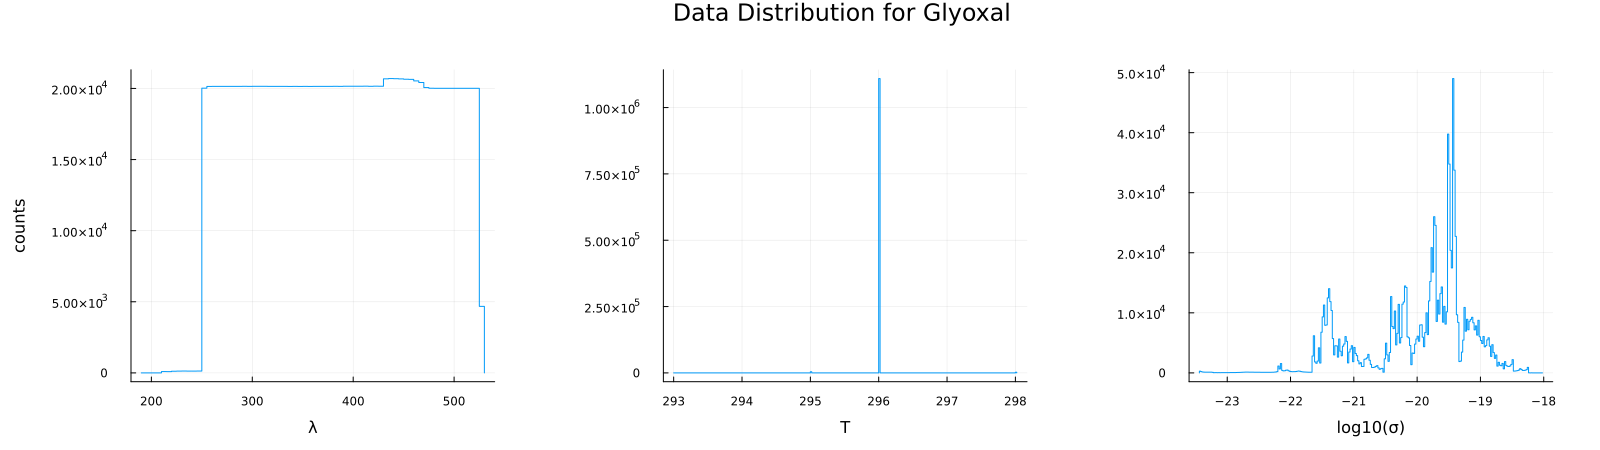

In [9]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(nice_name)")

In [10]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [11]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


# Data Preprocessing

In [12]:
gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

282546×3 DataFrame
    Row │ λ        σ          T       
        │ Float64  Float64    Float64 
────────┼─────────────────────────────
      1 │  290.0   3.21e-20     293.0
      2 │  300.0   3.71e-20     293.0
      3 │  310.0   2.65e-20     293.0
      4 │  320.0   1.51e-20     293.0
      5 │  330.0   1.42e-20     293.0
      6 │  340.0   5.6e-20      293.0
      7 │  350.0   6.3e-21      293.0
      8 │  360.0   6.4e-21      293.0
      9 │  370.0   8.8e-20      293.0
     10 │  380.0   2.75e-20     293.0
     11 │  390.0   2.85e-20     293.0
   ⋮    │    ⋮         ⋮         ⋮
 282537 │  455.64  2.373e-19    298.0
 282538 │  456.34  3.074e-19    298.0
 282539 │  456.69  4.076e-19    298.0
 282540 │  457.45  2.237e-19    298.0
 282541 │  457.92  1.4e-19      298.0
 282542 │  457.97  7.985e-20    298.0
 282543 │  459.25  1.281e-20    298.0
 282544 │  459.83  6.036e-21    298.0
 282545 │  461.1   2.505e-21    298.0
 282546 │  193.0   4.8e-19      298.0
                   282525 rows omitted

In [13]:
df_unique = filter_outliers(df_unique, log10.(df_unique.σ))
println(nrow(df_unique))

# df_unique = df_unique[df_unique.T .!= 298.0, :]

278863


In [14]:
λ_idxs = representative_rand_sample(df_unique.λ, 1000, 2000)
# T_idxs = representative_rand_sample(df_unique.λ, 5, 500)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 

# idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs,σ_idxs)))
idxs_res = shuffle(unique(vcat(λ_idxs, σ_idxs)))


df_sampled = df_unique[idxs_res, :]

println(size(df_sampled))

max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

(2648, 3)


209.4

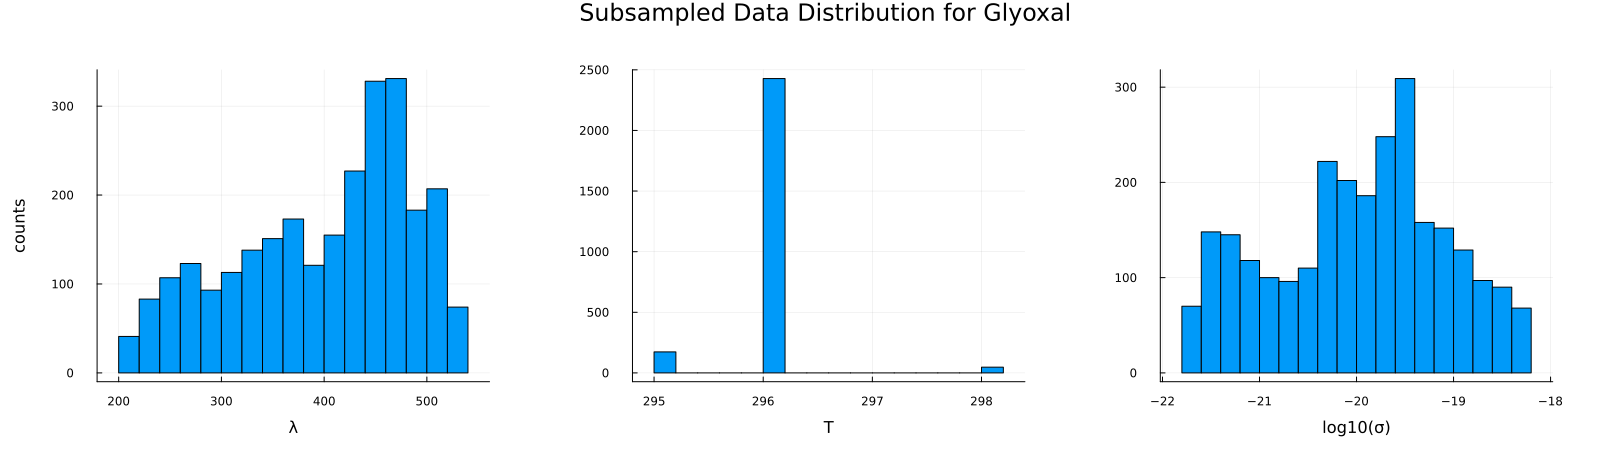

In [15]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

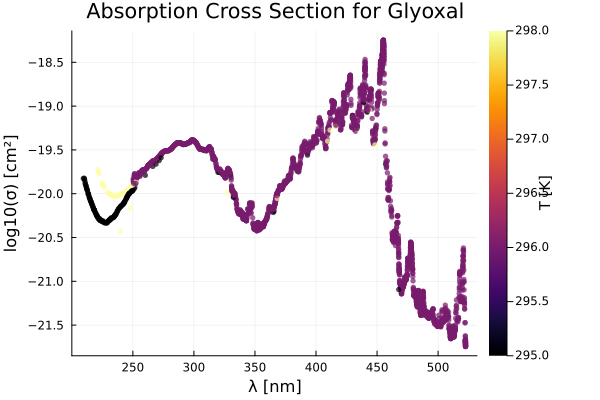

In [16]:
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [49]:
train_frac = 0.85
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

2250


In [50]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

398-element Vector{Float64}:
 -19.66054855869356
 -20.27823471200382
 -19.03147035562516
 -20.32316743837206
 -19.09388054245444
 -18.369267107182804
 -18.566070234391535
 -20.66054855869356
 -19.813608784304506
 -21.20453710560962
 -20.98589967848038
 -18.587707490676955
 -21.040720049869062
   ⋮
 -20.011198548002678
 -19.676747899828314
 -20.2057211342786
 -19.406160338918728
 -19.79209646961395
 -19.491201034596095
 -21.450383760480914
 -20.59674217421289
 -18.954677021213342
 -21.630413109263657
 -19.285167487566667
 -19.58385896883167

In [51]:
# compute length scales
#κ = 1
ℓ_λ = 5.0 # std(Xtrain.λ)/κ
ℓ_T = 0.1 # std(Xtrain.T)/κ

# compute variance parameters
SNR = 5
σf² = var(ytrain)
σₙ² = 0.001 # (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))

function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [52]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-0.22997593127434196, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(1.6094379094538682, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-2.3025852420056685, exp, 1.4901161193847656e-8)), 
  σ² = 0.001, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [53]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0     6.349646e+03     6.957554e+03
 * time: 0.00014781951904296875
     1     8.000292e+02     9.836598e+02
 * time: 22.541125774383545
     2    -4.368499e+02     8.997871e+02
 * time: 26.37592101097107
     3    -9.972219e+02     7.709394e+02
 * time: 31.37451696395874
     4    -1.184320e+03     6.925387e+02
 * time: 33.85095191001892
     5    -1.525580e+03     4.179687e+02
 * time: 36.513850927352905
     6    -1.653032e+03     7.189444e+01
 * time: 39.08955979347229
     7    -1.661872e+03     5.984993e+01
 * time: 43.062880992889404
     8    -1.682760e+03     3.466327e+01
 * time: 48.82748985290527
     9    -1.683837e+03     1.562774e+01
 * time: 51.820472955703735
    10    -1.684068e+03     3.075941e+00
 * time: 55.96147298812866
    11    -1.684071e+03     2.364227e-02
 * time: 59.88160300254822
    12    -1.684072e+03     2.705476e-02
 * time: 62.74204182624817
    13    -1.684074e+03     5.728696e-02
 * time: 122.902691841125

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @280 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @658 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [54]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [3.9417867879001354, 1.8171494044598546, -2.3031983808821144, -4.844989197370011],
 minimum = -1684.0732921049375,
 iterations = 38,
 converged = false,)

In [55]:
fp = fitted_params(mach)

(θ_best = [:σf² => 51.51055757877805, :ℓ_λ => 6.154290044739574, :ℓ_T => 0.09993870491461208],
 σ² = 0.007867717347567053,)

In [56]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

now let's collect some more points in order to evaluate our model using indices other than the ones used during training. 


┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


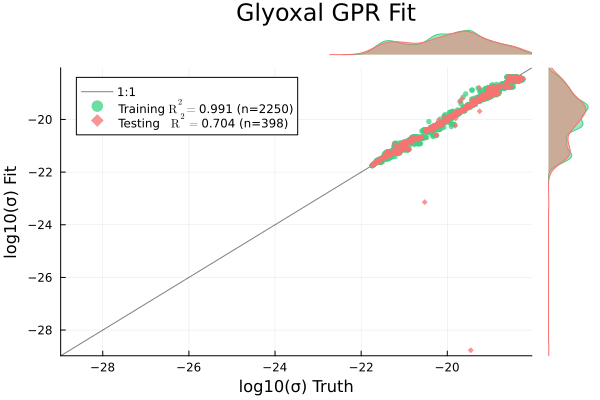

In [57]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)


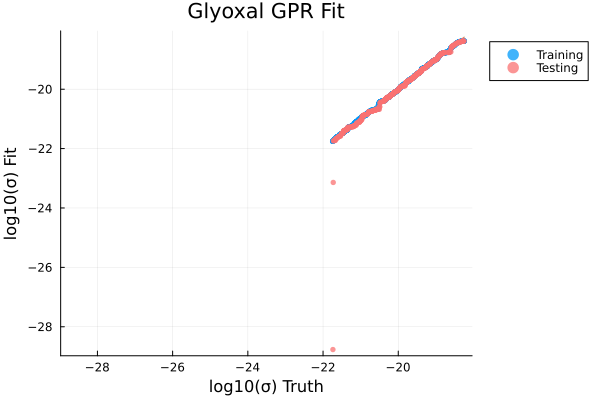

In [58]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


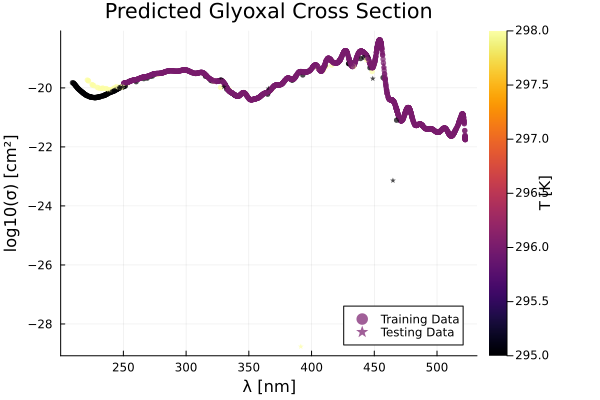

In [59]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)


Finally, let's try prediction at the desired wavelength bins: 

209.4
522.488


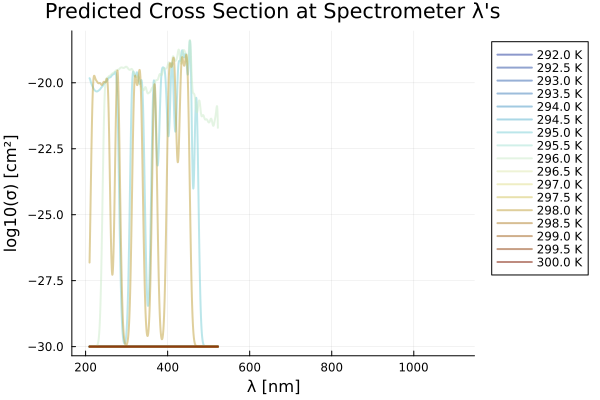

In [60]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

function predict_logσ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = predict_mean(mach, Xout)
    
    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    res[idxs] .= NaN 
    return res
end



p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

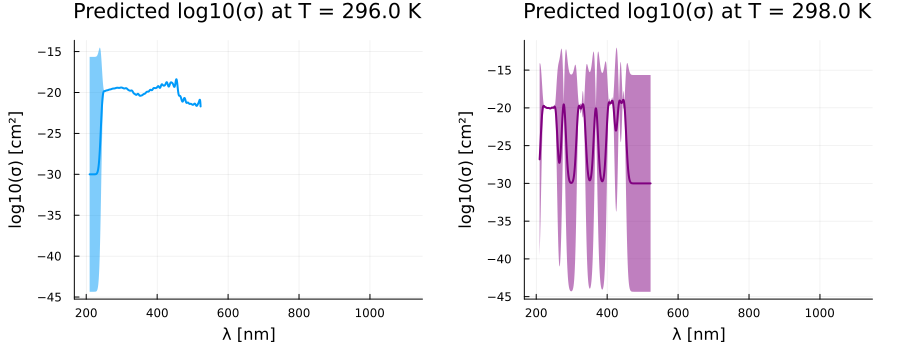

In [61]:
function predict_logσ_wΔ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = MLJ.predict(mach, Xout)

    logσ = mean.(res)
    Δlogσ = std.(res)

    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    logσ[idxs] .= NaN 
    Δlogσ[idxs] .= NaN 
    return logσ, Δlogσ
    #return res
end

Tplot = 296.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 

# Output for Photolysis Rate Determination

In [62]:
df_photolysis_σ = CSV.File("../photolysis_σ.csv") |> DataFrame 

describe(df_photolysis_σ)

23×7 DataFrame
 Row │ variable  mean           min      median         max             nmissi ⋯
     │ Symbol    Float64        Float64  Float64        Float64         Int64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ         667.499        194.249  672.636        1120.22                ⋯
   2 │ σ_1         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   3 │ σ_2         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   4 │ σ_3         2.15632e-20    0.0      0.0             7.82292e-19
   5 │ σ_4         1.25113e-19    0.0      6.4171e-21      6.41009e-19         ⋯
   6 │ σ_5         6.58792e-19    0.0      1.71951e-28     1.5094e-17
   7 │ σ_6         6.58792e-19    0.0      1.71951e-28     1.5094e-17
   8 │ σ_7         8.4788e-20     0.0      0.0             2.33417e-18
   9 │ σ_8         8.92125e-20    0.0      0.0             1.11355e-17         ⋯
  10 │ σ_11        1.9483e-21     0.0      0.0             9.32842e-20
  11 │ σ_12        1.9483e-21     0.0      0.0             9.32842e-20
  ⋮  │    ⋮            ⋮           ⋮           ⋮              ⋮            ⋮   ⋱
  14 │ σ_17        3.30084e-21    0.0      0.0             6.13397e-20
  15 │ σ_15        4.48024e-16    0.0      0.0             9.21262e-13         ⋯
  16 │ σ_16        4.48024e-16    0.0      0.0             9.21262e-13
  17 │ σ_18        5.27254e-19    0.0      0.0             2.65473e-17
  18 │ σ_19        5.27254e-19    0.0      0.0             2.65473e-17
  19 │ σ_20        5.27254e-19    0.0      0.0             2.65473e-17         ⋯
  20 │ σ_21        2.90646e-21    0.0      0.0             7.47785e-20
  21 │ σ_22        1.81346e-21    0.0      0.0             7.83071e-20
  22 │ σ_23        4.48449e-21    0.0      0.0             6.62263e-20
  23 │ σ_24        4.48449e-21    0.0      0.0             6.62263e-20         ⋯
                                                    2 columns and 2 rows omitted

In [63]:
λ_min = minimum(df_sampled.λ)
λ_max = maximum(df_sampled.λ)

println(λ_min, "\t", minimum(df_photolysis_σ.λ))
println(λ_max, "\t", maximum(df_photolysis_σ.λ))

209.4	194.249
522.488	1120.216


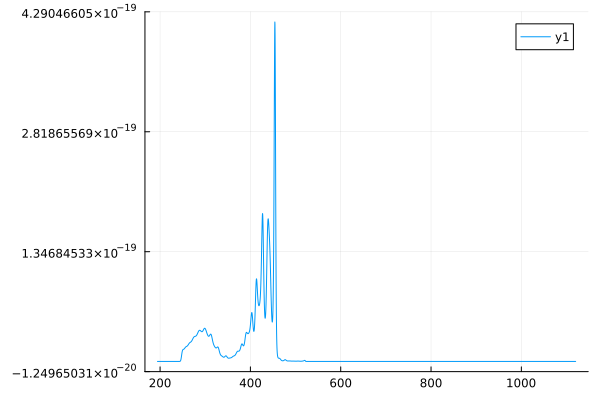

In [64]:
Tplot = 296.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

σ = 10 .^ logσ

replace!(σ, NaN => 0.0)

# set anything outside of λ range to 0 as well
σ[hr4000_df.λ .< λ_min .|| hr4000_df.λ .> λ_max] .= 0.0


plot(hr4000_df.λ, σ)

In [65]:
df_photolysis_σ.σ_31 = σ
df_photolysis_σ.σ_32 = σ
df_photolysis_σ.σ_33 = σ

describe(df_photolysis_σ)

26×7 DataFrame
 Row │ variable  mean           min      median         max             nmissi ⋯
     │ Symbol    Float64        Float64  Float64        Float64         Int64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ         667.499        194.249  672.636        1120.22                ⋯
   2 │ σ_1         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   3 │ σ_2         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   4 │ σ_3         2.15632e-20    0.0      0.0             7.82292e-19
   5 │ σ_4         1.25113e-19    0.0      6.4171e-21      6.41009e-19         ⋯
   6 │ σ_5         6.58792e-19    0.0      1.71951e-28     1.5094e-17
   7 │ σ_6         6.58792e-19    0.0      1.71951e-28     1.5094e-17
   8 │ σ_7         8.4788e-20     0.0      0.0             2.33417e-18
   9 │ σ_8         8.92125e-20    0.0      0.0             1.11355e-17         ⋯
  10 │ σ_11        1.9483e-21     0.0      0.0             9.32842e-20
  11 │ σ_12        1.9483e-21     0.0      0.0             9.32842e-20
  ⋮  │    ⋮            ⋮           ⋮           ⋮              ⋮            ⋮   ⋱
  17 │ σ_18        5.27254e-19    0.0      0.0             2.65473e-17
  18 │ σ_19        5.27254e-19    0.0      0.0             2.65473e-17         ⋯
  19 │ σ_20        5.27254e-19    0.0      0.0             2.65473e-17
  20 │ σ_21        2.90646e-21    0.0      0.0             7.47785e-20
  21 │ σ_22        1.81346e-21    0.0      0.0             7.83071e-20
  22 │ σ_23        4.48449e-21    0.0      0.0             6.62263e-20         ⋯
  23 │ σ_24        4.48449e-21    0.0      0.0             6.62263e-20
  24 │ σ_31        1.00573e-20    0.0      0.0             4.1655e-19
  25 │ σ_32        1.00573e-20    0.0      0.0             4.1655e-19
  26 │ σ_33        1.00573e-20    0.0      0.0             4.1655e-19          ⋯
                                                    2 columns and 5 rows omitted

In [66]:
CSV.write("../photolysis_σ.csv", df_photolysis_σ)

"../photolysis_σ.csv"